In [1]:
import torch
import torchvision.models as models


device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

detection_model = models.detection.fasterrcnn_resnet50_fpn()

detection_model.to(device)


detection_model.load_state_dict(torch.load("model.pth"))

<All keys matched successfully>

In [2]:
from torchvision.transforms import v2 as T
import torch

def get_transform(train):
    transforms = []
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    transforms.append(T.ConvertImageDtype(torch.float32))  # Convert image dtype to float32
    transforms.append(T.ToDtype(torch.float32, scale=True))  # Convert to tensor
    return T.Compose(transforms)

In [3]:
import os

# Get the current working directory
current_dir = os.getcwd()

vegetable_dir = os.path.join(current_dir, 'ingredient_classification\\fruits_vegetables_ds\\train')
meat_dir = os.path.join(current_dir, 'ingredient_classification\\meat_ds\\train')
other_dir = os.path.join(current_dir, 'ingredient_classification\\misc_ds\\train')

vegetable_classes = [class_name for class_name in os.listdir(vegetable_dir)]
meat_classes = [class_name for class_name in os.listdir(meat_dir)]
other_classes = [class_name for class_name in os.listdir(other_dir)]

print(vegetable_classes)
print(meat_classes)
print(other_classes)


['apple', 'banana', 'beetroot', 'bell_pepper', 'cabbage', 'capsicum', 'carrot', 'cauliflower', 'chilli_pepper', 'corn', 'cucumber', 'eggplant', 'garlic', 'ginger', 'grapes', 'jalepeno', 'kiwi', 'lemon', 'lettuce', 'mango', 'onion', 'orange', 'paprika', 'pear', 'peas', 'pineapple', 'pomegranate', 'potato', 'raddish', 'soy_beans', 'spinach', 'sweetcorn', 'sweetpotato', 'tomato', 'turnip', 'watermelon']
['beef', 'chicken_meat', 'fish', 'goat_meat', 'shrimp']
['brown_rice', 'cereal', 'chocolate', 'egg', 'flour', 'rice']


In [4]:
import onnxruntime
import numpy as np
import torchvision.transforms as transforms

preprocess = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

ort_session_vegetable = onnxruntime.InferenceSession("vegetable_classifier.onnx")
ort_session_meat = onnxruntime.InferenceSession("meat_classifier.onnx")
ort_session_other = onnxruntime.InferenceSession("other_classifier.onnx")

def get_label(cropped_image):
    transformed_img = preprocess(cropped_image)
    transformed_img = transformed_img.unsqueeze(0)
    ort_inputs = {ort_session_vegetable.get_inputs()[0].name: transformed_img.numpy()}

    ort_outs = ort_session_vegetable.run(None, ort_inputs)
    onnx_output_veg = ort_outs[0]
    max_index_veg = np.argmax(onnx_output_veg)

    ort_outs = ort_session_meat.run(None, ort_inputs)
    onnx_output_meat = ort_outs[0]
    max_index_meat = np.argmax(onnx_output_meat)

    ort_outs = ort_session_other.run(None, ort_inputs)
    onnx_output_other = ort_outs[0]
    max_index_other = np.argmax(onnx_output_other)

    # max_output = max([np.max(onnx_output_veg), np.max(onnx_output_meat), np.max(onnx_output_other)])
    # if max_output == np.max(onnx_output_veg):
    #     label = vegetable_classes[max_index_veg]
    # if max_output == np.max(onnx_output_meat):
    #     label = meat_classes[max_index_meat]
    # if max_output == np.max(onnx_output_other):
    #     label = other_classes[max_index_other]

    label = vegetable_classes[max_index_veg]
    print("ONNX Runtime output prediction:", label)
    return label

ONNX Runtime output prediction: mango
ONNX Runtime output prediction: orange
tensor([[1656.9357,  396.5389, 3070.6179, 1863.8477],
        [ 117.1193,  507.0914, 1525.9869, 1909.0710]])


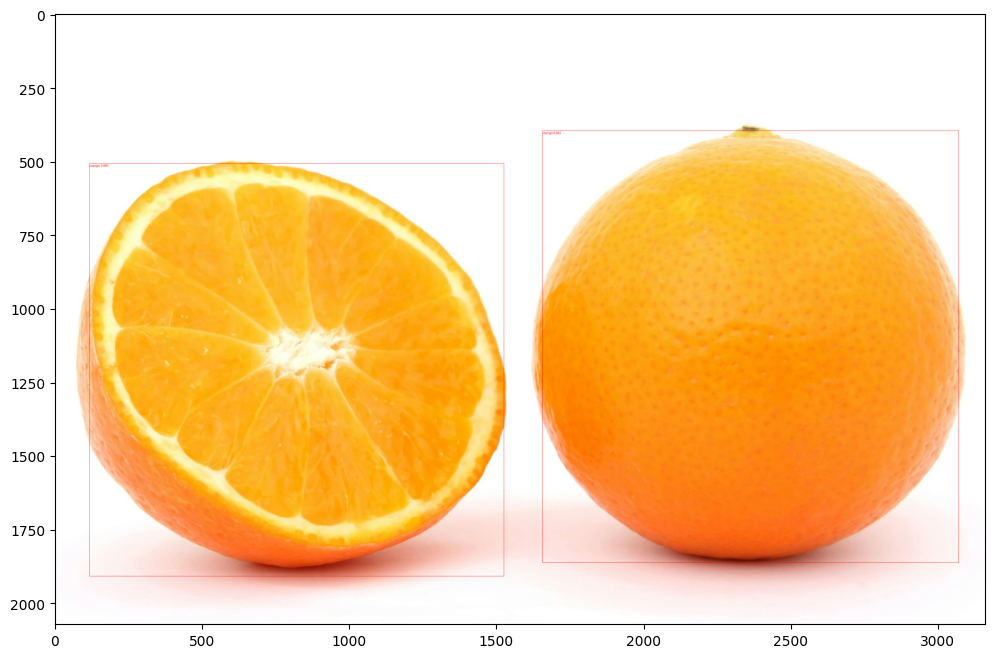

In [25]:
import matplotlib.pyplot as plt

from torchvision.utils import draw_bounding_boxes
from torchvision.io import read_image
from torchvision.transforms import functional as F
from PIL import Image


image = read_image("D:\\Facultate\\ELL\\food_recognition\\ingredient_identification\\mixed_ingredients_ds\\mixed_ingredients_195.jpg")
eval_transform = get_transform(train=False)

detection_model.eval()
with torch.no_grad():
    x = eval_transform(image)
    # convert RGBA -> RGB and move to device
    x = x[:3, ...].to(device)
    predictions = detection_model([x, ])
    pred = predictions[0]

# Assuming `image` is your original image tensor
# Convert to PIL image for cropping
pil_image = F.to_pil_image(image)

def create_image_from_box(box_list:list, pil_image:Image) -> Image:
    x_min, y_min, x_max, y_max = box_list
    # Crop the region of interest (ROI) from the image using the bounding box coordinates
    roi = pil_image.crop((x_min, y_min, x_max, y_max))
    
    # Create a new image with white background of the same size as the cropped ROI
    backround_width = int(roi.size[0] * 1.25)
    backround_height = int(roi.size[1] * 1.25)
    picture_with_backround = Image.new("RGB", (backround_width,backround_height), (255, 255, 255))
    
    # Paste the cropped ROI onto the white background
    # set the top left corner where the image will pe placed to center it
    top_left_corner = ((backround_width - roi.width) // 2, (backround_height - roi.height) // 2)
    picture_with_backround.paste(roi,top_left_corner)
    #picture_with_backround.show()
    return picture_with_backround

threshold = 0.5
pred_labels = []
pred_boxes = []
for label, score, box in zip(pred["labels"], pred["scores"], pred["boxes"]):
    if score > threshold:
        box_list = box.tolist()
        cropped_image = create_image_from_box(box_list,pil_image)
        predicted_label = get_label(cropped_image)
        pred_labels.append(f"{predicted_label}: {score:.3f}")
        pred_boxes.append(box_list)  # Convert box tensor to list

# Convert pred_boxes to tensor
pred_boxes = torch.tensor(pred_boxes, dtype=torch.float32)
print(pred_boxes)



image = (255.0 * (image - image.min()) / (image.max() - image.min())).to(torch.uint8)
image = image[:3, ...]
output_image = draw_bounding_boxes(image, pred_boxes, pred_labels, colors="red")

plt.figure(figsize=(12, 12))
plt.imshow(output_image.permute(1, 2, 0))
plt.show()